# Project 1 - part A

Dataset with the 30 Stocks from S&P500 Index from 2014 to 2024

In [210]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df = pd.read_csv("../project1-partA/project1_data.csv")
df_SP500 = pd.read_csv("../project1-partA/sp500_px_open_last.csv")
df = df.dropna() # VRTX has null PX_LAST in 2015-05-12	
df.head()

,Date,PX_LAST,CUR_MKT_CAP,PX_VOLUME,Ticker,Market_Value
0,2014-01-02,76.27,134027.7199,5212460.0,DIS,1.022229e+07
1,2014-01-03,76.11,133746.5552,4061042.0,DIS,1.017945e+07
2,2014-01-06,75.82,133236.9441,6816693.0,DIS,1.010203e+07
3,2014-01-07,76.34,134150.7295,4511157.0,DIS,1.024107e+07
4,2014-01-08,75.22,132182.5763,10914858.0,DIS,9.942773e+06


## Daily Return

In [211]:
tickers = df["Ticker"].unique()
all_tickers_df = []

for tik in tickers:
    mask = df["Ticker"]==tik
    last_day_value = df.loc[mask,'PX_LAST'].shift(1)
    today_value = df.loc[mask,'PX_LAST']
    
    # Daily Return
    df.loc[mask, 'Daily_Return'] = (today_value - last_day_value) / last_day_value

df.loc[df['Daily_Return'].isna(),"Daily_Return"] = 0
df['Date'] = pd.to_datetime(df['Date'])

last_day_value = df_SP500.loc[:,'PX Last'].shift(1)
today_value = df_SP500.loc[:,'PX Last']
df_SP500.loc[:,"Daily_Return"] = (today_value - last_day_value) / last_day_value
df_SP500.loc[df_SP500['Daily_Return'].isna(),"Daily_Return"] = 0
df_SP500 = df_SP500[df_SP500["Date"]<="2023-31-31"]

## Value-Weighted and Equally-Weighted Portfolio

In [212]:
def equal_weight_daily_returns(df):
    """
        This function receives a time series with the daily return of n stocks. At the end it will return a times series with same length
        with the daily returns of a equal weighted portfolio. The portfolio is rebalanced with the cumulative value at the end of every month
    """
    
    # This is the value that we start with (100%)
    cumulative_value = 1

    # Number of Tickers
    n_tickers = len(df["Ticker"].unique())

    # Group by year and month
    grouped = df.groupby([df['Date'].dt.year, df['Date'].dt.month])

    # This is a list of dataframes grouped by the month and year of the Date column
    dfs_by_month_year = [group.reset_index(drop=True) for _, group in grouped]

    # Setting the base weight that will be multiplied by the cumulative_value
    equal_weight = 1 / n_tickers 

    EWP_Returs = []

    for i in range(len(dfs_by_month_year)):
        # For the value weight calculate all value_Weight, without rebalancing
        df_specific_month_year = dfs_by_month_year[i]
        df_specific_month_year["Equal_Weight"] = cumulative_value*equal_weight
        
        # Calculate the portfolio daily return
        df_specific_month_year["Equal_weight*Daily_Return"] = df_specific_month_year["Equal_Weight"]*df_specific_month_year["Daily_Return"]
        EWP_daily_returns = df_specific_month_year.groupby("Date")["Equal_weight*Daily_Return"].sum().rename("EWP_daily_return")
        
        # Update the cumulative return after this month
        for EWP_daily_return in EWP_daily_returns:
            cumulative_value*=(1+EWP_daily_return)
            
        EWP_Returs.append(EWP_daily_returns)
        
    return pd.concat(EWP_Returs)

In [213]:
def value_weight_daily_returns(df):
    """
        This function receives a time series with the daily return of n stocks. At the end it will return a times series with same length
        with the daily returns of a value weighted portfolio. The portfolio is rebalanced with the cumulative value at the end of every month
    """
    # This is the value that we start with (100%)
    cumulative_value = 1
    VWP_Returns = []
    # Group by year and month
    grouped = df.groupby([df['Date'].dt.year, df['Date'].dt.month])

    # This is a list of dataframes grouped by the month and year of the Date column
    dfs_by_month_year = [group.reset_index(drop=True) for _, group in grouped]

    for i in range(len(dfs_by_month_year)):
        # Get the value weight for all the stocks at the first day of the month
        df_specific_month_year = dfs_by_month_year[i]
        first_day = df_specific_month_year["Date"].min()
        total_MKT_CAP_first_day = df_specific_month_year[df_specific_month_year["Date"]==first_day]["CUR_MKT_CAP"].sum()
        value_weight_and_stock = df_specific_month_year.loc[df_specific_month_year["Date"]==first_day,["CUR_MKT_CAP","Ticker"]]
        value_weight_and_stock["Value_Weight"] =  value_weight_and_stock["CUR_MKT_CAP"] / total_MKT_CAP_first_day
        df_specific_month_year = pd.merge(df_specific_month_year, value_weight_and_stock, on='Ticker')
        # print(len(df_specific_month_year))
        df_specific_month_year["Value_Weight"] = cumulative_value*df_specific_month_year["Value_Weight"] # Rebalanced with the capital in the last day of previous month
        df_specific_month_year["Value_Weight*Daily_Return"] = df_specific_month_year["Value_Weight"]*df_specific_month_year["Daily_Return"]
        VWP_daily_returns = df_specific_month_year.groupby("Date")["Value_Weight*Daily_Return"].sum().rename("VWP_daily_return")

        for VWP_daily_return in VWP_daily_returns:
            cumulative_value*=(1+VWP_daily_return)
            
        VWP_Returns.append(VWP_daily_returns)
        
    return pd.concat(VWP_Returns)

In [214]:
# Connecting all the dataframes

# This dataframe contains the daily return of both portfolios
portfolios = pd.DataFrame({
    "Daily_Return_with_Equal_Weighted_Portfolio": equal_weight_daily_returns(df),
    "Daily_Return_with_Value_Weighted_Portfolio": value_weight_daily_returns(df)
})

portfolios.reset_index(inplace=True)
portfolios

,Date,Daily_Return_with_Equal_Weighted_Portfolio,Daily_Return_with_Value_Weighted_Portfolio
0,2014-01-02,0.000000,0.000000
1,2014-01-03,0.004006,-0.000521
2,2014-01-06,0.000032,0.003497
3,2014-01-07,0.007440,0.007960
4,2014-01-08,0.003497,0.001489
...,...,...,...
2511,2023-12-22,0.005197,0.008378
2512,2023-12-26,0.022738,0.009202
2513,2023-12-27,-0.003188,-0.005845
2514,2023-12-28,0.001596,0.001482


## Annualized Average Return of both porfolios and S&P 500

In [215]:
# Compute annualized average return
annualized_df = portfolios.groupby(portfolios['Date'].dt.strftime('%Y'))[["Daily_Return_with_Equal_Weighted_Portfolio","Daily_Return_with_Value_Weighted_Portfolio"]].mean()*252
annualized_df.reset_index(inplace=True)
annualized_df.rename(columns={"Daily_Return_with_Equal_Weighted_Portfolio":"Average_Annual_Return_with_Equal_Weighted_Portfolio","Daily_Return_with_Value_Weighted_Portfolio":"Average_Annual_Return_with_Value_Weighted_Portfolio"},inplace=True)
annualized_dfSP500 = (df_SP500.groupby(portfolios['Date'].dt.strftime('%Y'))["Daily_Return"].mean()*252).to_list()
annualized_df["Average_Annual_Return_with_SP500_Portfolio"] = annualized_dfSP500

In [216]:
annualized_df

,Date,Average_Annual_Return_with_Equal_Weighted_Portfolio,Average_Annual_Return_with_Value_Weighted_Portfolio,Average_Annual_Return_with_SP500_Portfolio
0,2014,0.239542,0.107372,0.122920
1,2015,0.014034,0.141717,0.003946
2,2016,0.249644,0.119752,0.100687
3,2017,0.334828,0.334420,0.180231
4,2018,-0.124841,-0.086713,-0.051167
5,2019,0.552997,0.493617,0.260965
6,2020,-0.034457,0.207112,0.205756
7,2021,0.955253,1.173304,0.247972
8,2022,-0.279740,-1.037498,-0.188107
9,2023,0.573372,0.584885,0.227913


## Annualized Standard Deviation

In [217]:
# compute annualized standard deviation return
standard_deviation_return = portfolios.groupby(portfolios['Date'].dt.strftime('%Y'))[["Daily_Return_with_Equal_Weighted_Portfolio","Daily_Return_with_Value_Weighted_Portfolio"]].std(ddof=0) * np.sqrt(252)
standard_deviation_return.reset_index(inplace=True)
standard_deviation_return = standard_deviation_return.rename(columns={"Daily_Return_with_Equal_Weighted_Portfolio":"Standard_Deviation_with_Equal_Weighted_Portfolio","Daily_Return_with_Value_Weighted_Portfolio":"Standard_Deviation_with_Value_Weighted_Portfolio"})
standard_deviation_return_SP500 = (df_SP500.groupby(portfolios['Date'].dt.strftime('%Y'))["Daily_Return"].std(ddof=0)*np.sqrt(252)).to_list()
standard_deviation_return["Standard_Deviation_with_SP500_Portfolio"] = standard_deviation_return_SP500

In [218]:
standard_deviation_return

,Date,Standard_Deviation_with_Equal_Weighted_Portfolio,Standard_Deviation_with_Value_Weighted_Portfolio,Standard_Deviation_with_SP500_Portfolio
0,2014,0.151781,0.148894,0.112173
1,2015,0.215832,0.209351,0.155441
2,2016,0.221749,0.188618,0.131082
3,2017,0.149834,0.136968,0.067574
4,2018,0.407061,0.407541,0.170989
5,2019,0.321539,0.300041,0.125255
6,2020,0.789416,0.708496,0.334469
7,2021,0.496037,0.750200,0.130795
8,2022,0.846607,0.810398,0.242203
9,2023,0.421825,0.343680,0.131624


In [219]:
# CHANGE THIS VALUE FOR A REAL VALUE
risk_free_annual_rate = 0.0559
risk_free_daily = ((risk_free_annual_rate + 1)/1)**(1/365)-1

portfolios["risk_free_daily_return"] = risk_free_daily

## Sharpe Ratio and Information Ratio with annualized Average Return

In [220]:
annualized_df["Excess_Return_EWP"] = annualized_df["Average_Annual_Return_with_Equal_Weighted_Portfolio"] - risk_free_annual_rate
risk_premium_EWP = annualized_df["Excess_Return_EWP"].mean()
SD_Excess_Return_EWP = annualized_df["Excess_Return_EWP"].std(ddof=0)
sharpe_ratio_EWP = risk_premium_EWP / SD_Excess_Return_EWP
print(sharpe_ratio_EWP)

0.5416268840455257


## Plot cumulative returns for both porfolios, S&P 500 and risk-free using daily returns

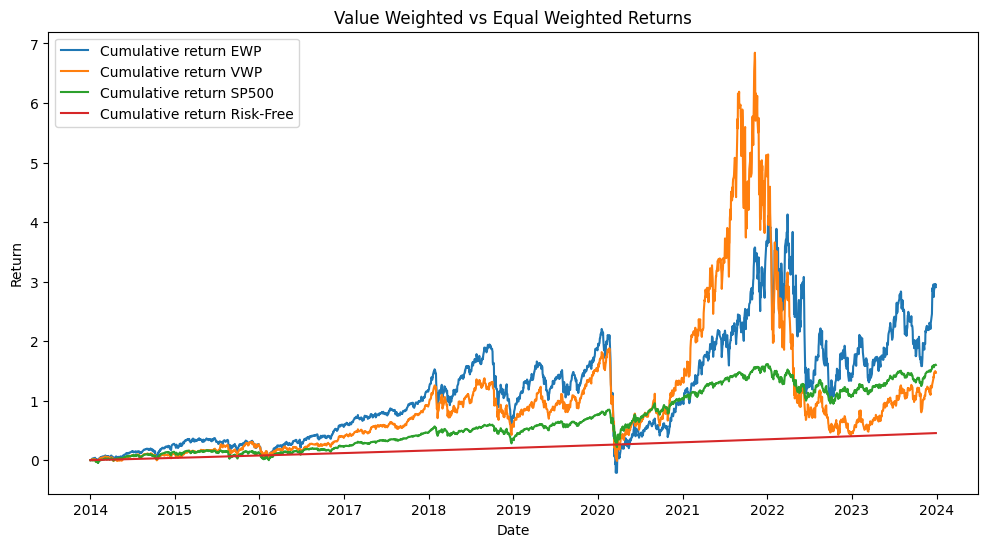

In [221]:
cumulative_returns_EWP = (portfolios["Daily_Return_with_Equal_Weighted_Portfolio"]+1).cumprod() - 1
cumulative_returns_VWP = (portfolios["Daily_Return_with_Value_Weighted_Portfolio"]+1).cumprod() - 1
cumulative_returns_RiskFree = (portfolios["risk_free_daily_return"]+1).cumprod() - 1
cumulative_returns_SP500 = (df_SP500["Daily_Return"]+1).cumprod() - 1

plt.figure(figsize=(12, 6))
plt.plot(portfolios["Date"], cumulative_returns_EWP, label="Cumulative return EWP")
plt.plot(portfolios["Date"], cumulative_returns_VWP, label="Cumulative return VWP")
plt.plot(portfolios["Date"], cumulative_returns_SP500, label="Cumulative return SP500")
plt.plot(portfolios["Date"], cumulative_returns_RiskFree, label="Cumulative return Risk-Free")

plt.title(f"Value Weighted vs Equal Weighted Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()

In [222]:
# This is to use in part B (I think)
# Expected post Returns
ex_post_return = annualized_df["Average_Annual_Return_with_Equal_Weighted_Portfolio"].mean()
print(portfolios["Daily_Return_with_Equal_Weighted_Portfolio"].mean()*252)
# risk = returns_per_year["Annually_Return_EWP"].std()
print(ex_post_return)
# print(risk)

0.24801592937805722
0.24806330417679429
